In [1]:
import torch
import torchvision
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import models.Autoencoder as AE

In [2]:
hidden_size = (256,32)
model = AE.VariationalAutoencoder(input_size=(28,28), hidden_size=hidden_size)

In [3]:
#model_path = '../trained_models/VAE_MNIST_2019-03-10_22:52:35.332881_overfitted'
model_path = '../trained_models/VAE_MNIST_2019-03-10_22:58:24.932630'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()

In [5]:
loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('../data', train=False, download=True,
                       transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                        batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


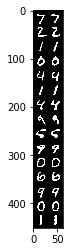

In [20]:
imgs = []
n = 15
for i, (data, target) in enumerate(loader):
    if i > n-1:
        break
    imgs.append(data.squeeze(0))
    mu, log_var = model.encode(data.cuda())
    z = model.sample_z(mu, log_var)
    rec = model.decode(z)
    rec = rec.detach().cpu()
    imgs.append(rec.squeeze(0))

imgs = make_grid(imgs, nrow=2)
imgs = np.moveaxis(imgs.numpy(), 0, -1)
plt.imshow(imgs)
plt.show()

In [7]:
eps = torch.randn(hidden_size[1])
if cuda:
    eps = eps.cuda()
img = model.decode(eps)
img = img.squeeze().detach().cpu().numpy()
print(img.shape)

(28, 28)


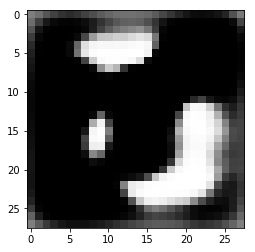

In [8]:
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

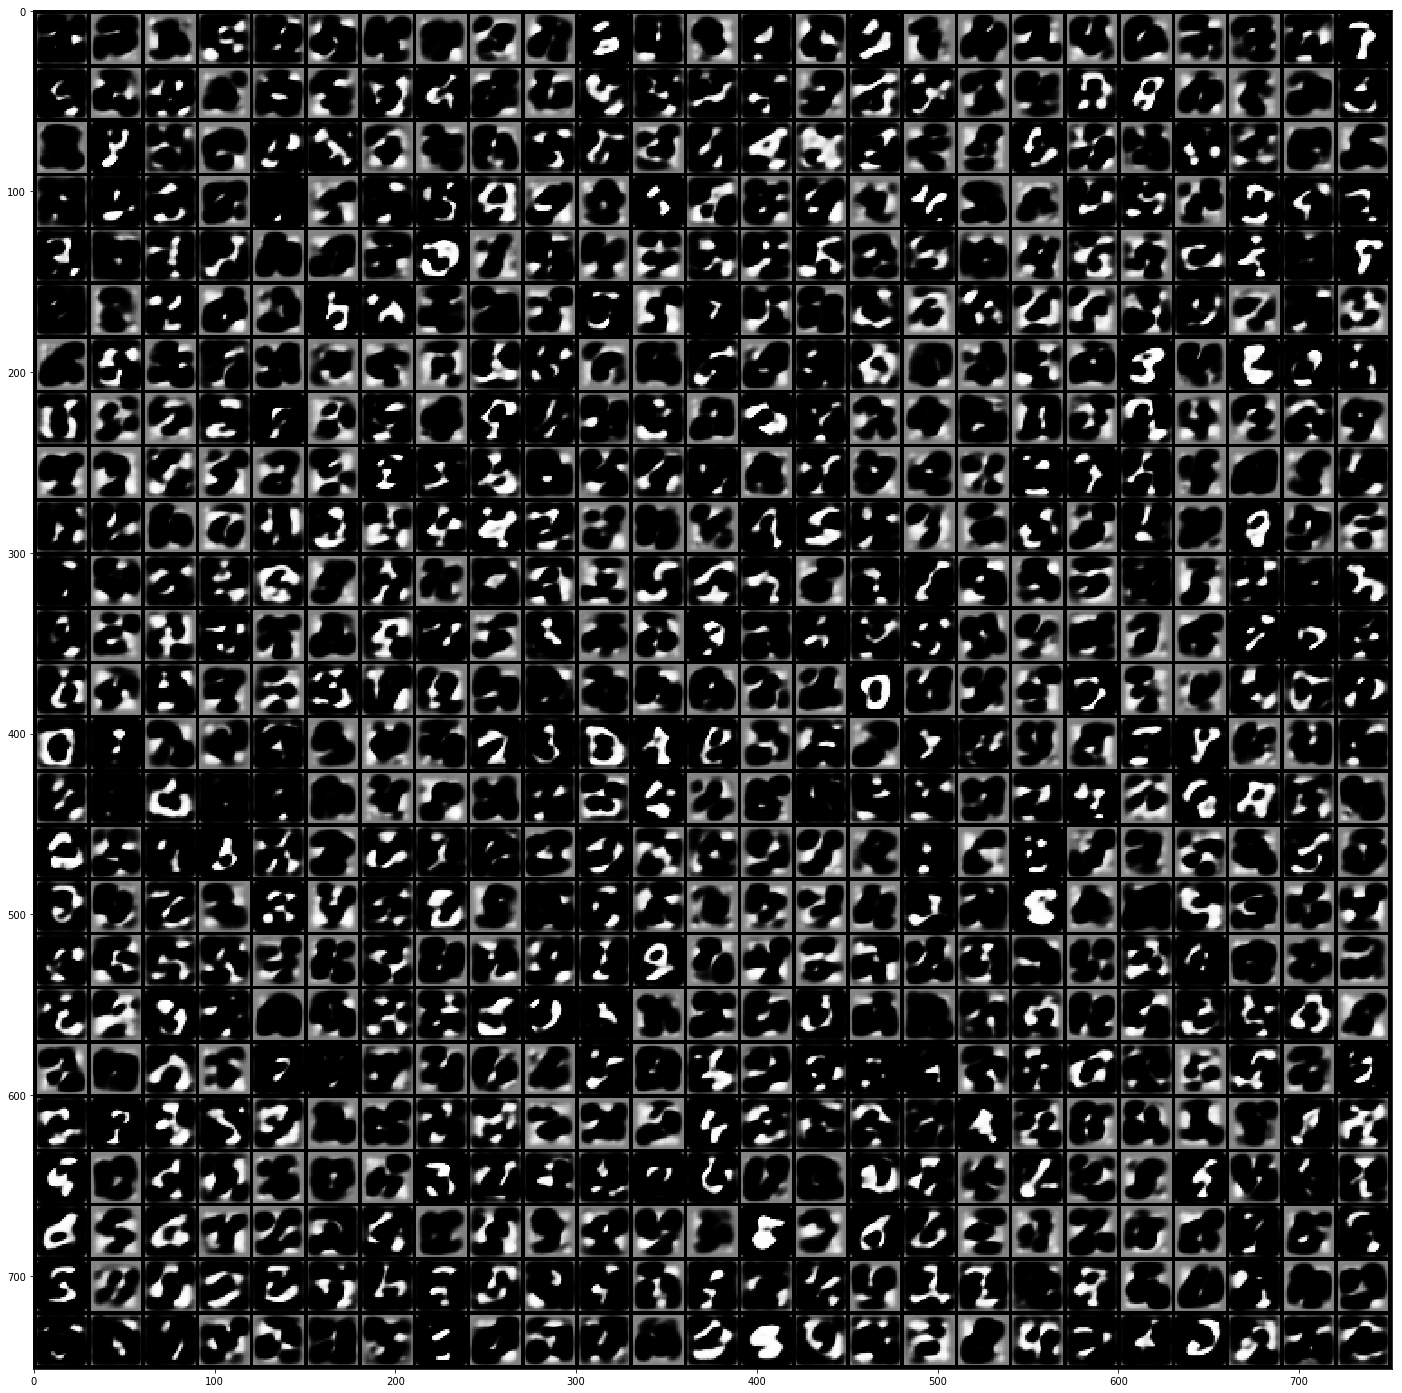

In [9]:
square = 25
imgs = []
for i in range(square**2):
    eps = torch.randn(hidden_size[1])
    if cuda:
        eps = eps.cuda()
    img = model.decode(eps)
    img = img.squeeze(0).detach().cpu()
    imgs.append(img)
imgs = make_grid(imgs, nrow=square)
plt.figure(figsize=(square, square))
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.show()